In [1]:
# USAGE
# python3 opencv_text_detection_image.py --image images/lebron_james.jpg --east frozen_east_text_detection.pb

# import the necessary packages
from imutils.object_detection import non_max_suppression
import numpy as np
import time
import cv2
from utils.image import showImage
import matplotlib.pyplot as plt

import pytesseract
from utils.image import toGrayscale, denoise, thresholding, blackhat, whiteSquarify, showImage

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100

In [3]:
# load the input image and grab the image dimensions
image = cv2.imread('./data/train/cni2.jpg')
orig = image.copy()
(H, W) = image.shape[:2]

# set the new width and height and then determine the ratio in change
# for both the width and height
(newW, newH) = (640, 640)
rW = W / float(newW)
rH = H / float(newH)

# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

In [4]:
# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"]

# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet('./frozen_east_text_detection.pb')

[INFO] loading EAST text detector...


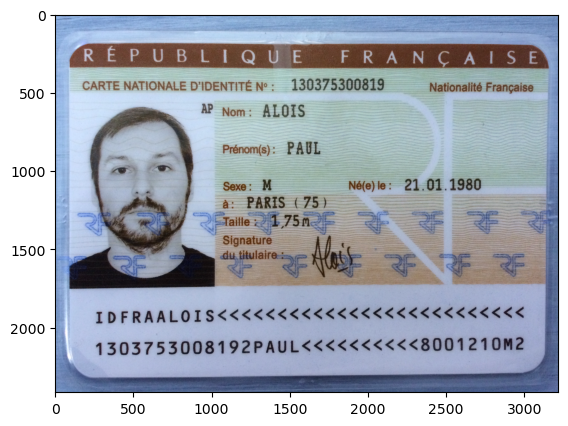

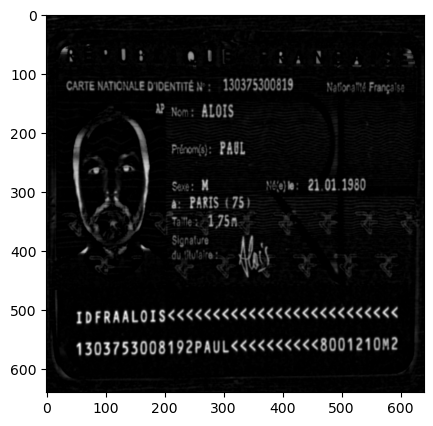

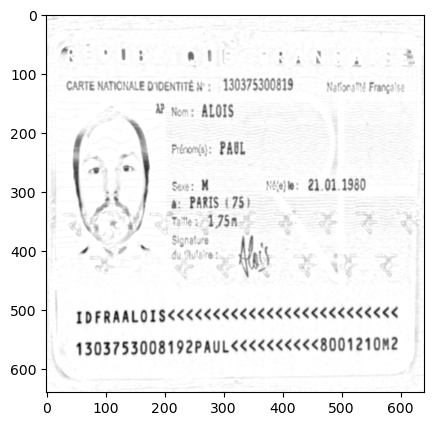

In [5]:
showImage(orig, gray=True)
gray = toGrayscale(image)
blurred = denoise(gray, 5)
bh = blackhat(blurred, (13,5))
showImage(bh, gray=True)
dst=cv2.bitwise_not(bh)
showImage(dst, gray=True)
img2 = cv2.merge((dst,dst,dst))

In [6]:
# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(img2, 1.0, (W, H),
                             (123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()

# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))

[INFO] text detection took 0.468829 seconds


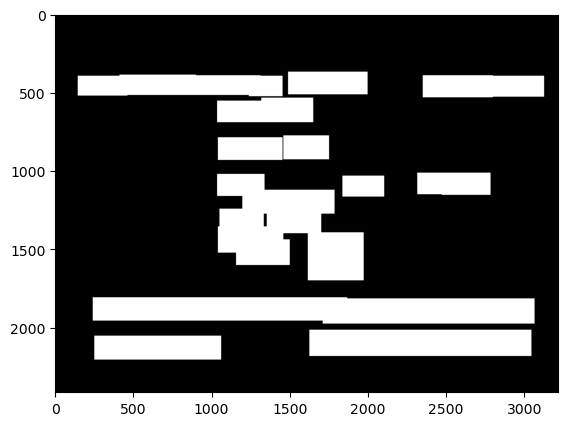

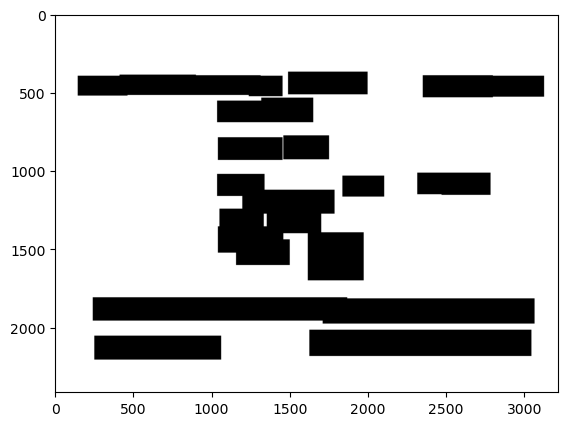

In [7]:
# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

mask = np.zeros(orig.shape[:2], dtype="uint8")

# loop over the number of rows
for y in range(0, numRows):
    # extract the scores (probabilities), followed by the geometrical
    # data used to derive potential bounding box coordinates that
    # surround text
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]

    # loop over the number of columns
    for x in range(0, numCols):
        # if our score does not have sufficient probability, ignore it
        if scoresData[x] < 0.5:
            continue

        # compute the offset factor as our resulting feature maps will
        # be 4x smaller than the input image
        (offsetX, offsetY) = (x * 4.0, y * 4.0)

        # extract the rotation angle for the prediction and then
        # compute the sin and cosine
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)

        # use the geometry volume to derive the width and height of
        # the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]

        # compute both the starting and ending (x, y)-coordinates for
        # the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)

        # add the bounding box coordinates and probability score to
        # our respective lists
        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])

# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)

# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)

    # draw the bounding box on the image
    # cv2.rectangle(orig, (startX-20, startY-20), (endX+50, endY+30), (0, 255, 0), 5)
    cv2.rectangle(mask, (startX-20, startY-20), (endX+50, endY+30), 255, -1)

# show the output image
# showImage(orig, gray=True)
showImage(mask, gray=True)

invertedMask = cv2.bitwise_not(mask)
showImage(invertedMask, gray=True)



#cv2.imshow("Text Detection", orig)
#cv2.waitKey(0)

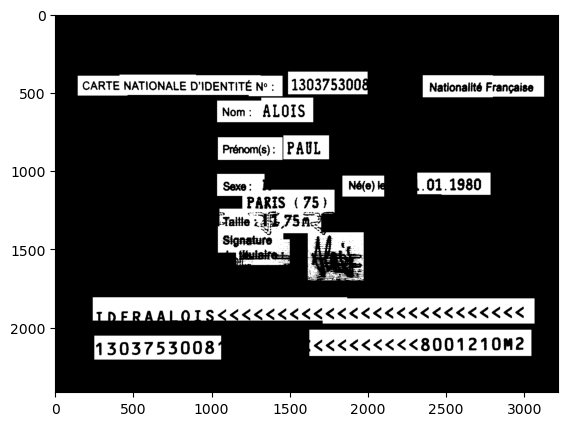

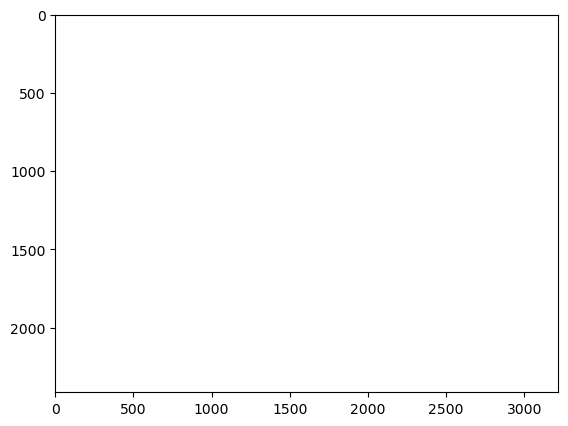

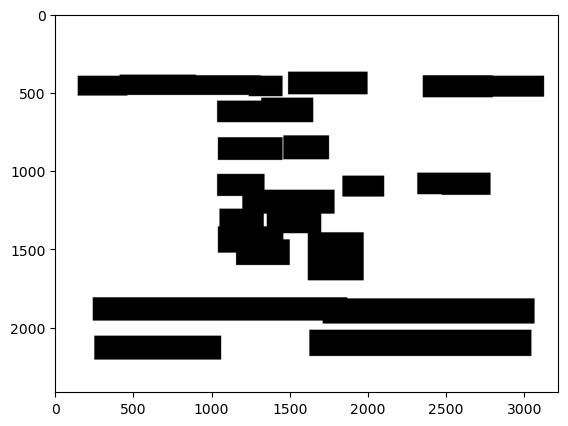

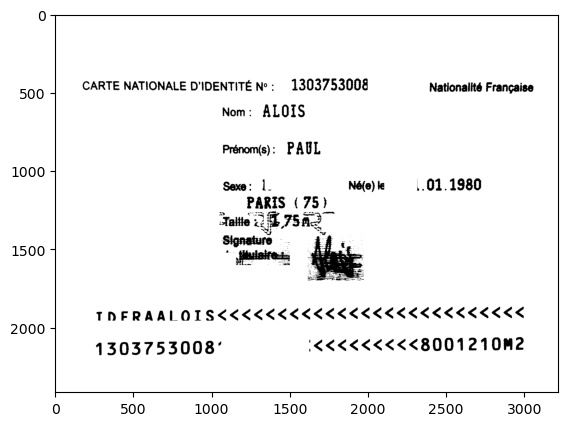

In [8]:
gray = toGrayscale(orig)
blurred = denoise(gray, 5)
_, th = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

th2 = cv2.merge((th,th,th))

masked = cv2.bitwise_and(th2, th2, mask=mask)
showImage(masked, gray=True)


white = np.zeros(orig.shape[:3], dtype="uint8")
white.fill(255)
showImage(white, gray=True)

img1_bg = cv2.bitwise_and(white,white,mask = invertedMask)
showImage(img1_bg)



final = cv2.add(img1_bg,masked)
showImage(final, gray=True)

#eroded = cv2.erode(final, None, iterations=1)
#showImage(eroded, gray=True)



In [9]:
#custom_config = r'--oem 3 --psm 6 -c load_system_dawg=false load_freq_dawg=false load_unambig_dawg=false load_punc_dawg=false load_number_dawg=false load_fixed_length_dawgs=false load_bigram_dawg=false wordrec_enable_assoc=false'
custom_config = r'--oem 3 --psm 6'

full = pytesseract.image_to_string(final, config=custom_config, lang='fra+mrz')
print(full)

CARTE NATIONALE D'IDENTITÉ N°: 1303753008 Nationalité Française
Nom: ALOIS
Prénom(s): PAUL
Sexe: 1_ Né(e) le ,.01.1980
PARIS (75)
Faite LE 7502
TBDBFRAAILOIS<<<<<<<<<<<<<<<<<<<<<<<<<<
1303753008 <<<<<<<<<8001210M2



In [65]:


# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", type=str,
                help="path to input image")
ap.add_argument("-east", "--east", type=str,
                help="path to input EAST text detector")
ap.add_argument("-c", "--min-confidence", type=float, default=0.5,
                help="minimum probability required to inspect a region")
ap.add_argument("-w", "--width", type=int, default=320,
                help="resized image width (should be multiple of 32)")
ap.add_argument("-e", "--height", type=int, default=320,
                help="resized image height (should be multiple of 32)")
args = vars(ap.parse_args())






NameError: name 'argparse' is not defined